In [2]:
# !pip install psycopg2

In [3]:
# database.py
host = 'localhost'
database ='demo_db'
user ='postgres'
password ='pgpassword'

In [4]:
# main.py
import psycopg2
# Connessione al database
def pg_connection():
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    cur = conn.cursor()
    return conn, cur


In [4]:
# check if table exists
conn, cur = pg_connection()
cur.execute('''
SELECT EXISTS (
    SELECT 1
    FROM information_schema.tables
    WHERE table_name = 'sales'
)
''')
exists = cur.fetchone()[0]
if exists:
    print('Table already exists')
else:
    # Create a new table with additional columns
    cur.execute('''
    CREATE TABLE sales (
        id SERIAL PRIMARY KEY,
        date DATE NOT NULL,
        quantity INT NOT NULL,
        price NUMERIC NOT NULL,
        product_category VARCHAR(50),
        customer_region VARCHAR(50)
    )
    ''')

In [5]:
# Inserimento di dati
if not exists:
    cur.execute('''
    INSERT INTO sales (date, quantity, price, product_category, customer_region) VALUES
    ('2023-04-01', 10, 20.5, 'Electronics', 'North'),
    ('2023-04-01', 5, 100.0, 'Furniture', 'South'),
    ('2023-04-02', 15, 22.5, 'Electronics', 'East'),
    ('2023-04-02', 7, 150.0, 'Furniture', 'West'),
    ('2023-04-03', 12, 19.0, 'Electronics', 'North'),
    ('2023-04-03', 20, 90.0, 'Furniture', 'East'),
    ('2023-04-04', 20, 25.0, 'Electronics', 'South'),
    ('2023-04-04', 8, 45.0, 'Furniture', 'North');
    ''')
    conn.commit()

Eseguiamo alcune query sulla tabella sales:

In [6]:
# Query to select the sum of sales per day

# è una query che serve per calcolare la somma totale delle vendite giornaliere in un database. La query seleziona due colonne: date e total_sales. Per calcolare total_sales, moltiplica la quantità (quantity) per il prezzo (price) di ciascun articolo venduto, e poi somma questi prodotti per ogni data. Dopo aver raggruppato i dati per data con GROUP BY date, li ordina in base alla data stessa utilizzando ORDER BY date. Il risultato finale mostra l'andamento delle vendite per ogni giorno.
cur.execute('''
SELECT date, SUM(quantity * price) AS total_sales
FROM sales
GROUP BY date
ORDER BY date;
''')

# Fetch data
data = cur.fetchall()
print(data)

[(datetime.date(2023, 4, 1), Decimal('705.0')), (datetime.date(2023, 4, 2), Decimal('1387.5')), (datetime.date(2023, 4, 3), Decimal('2028.0')), (datetime.date(2023, 4, 4), Decimal('860.0'))]


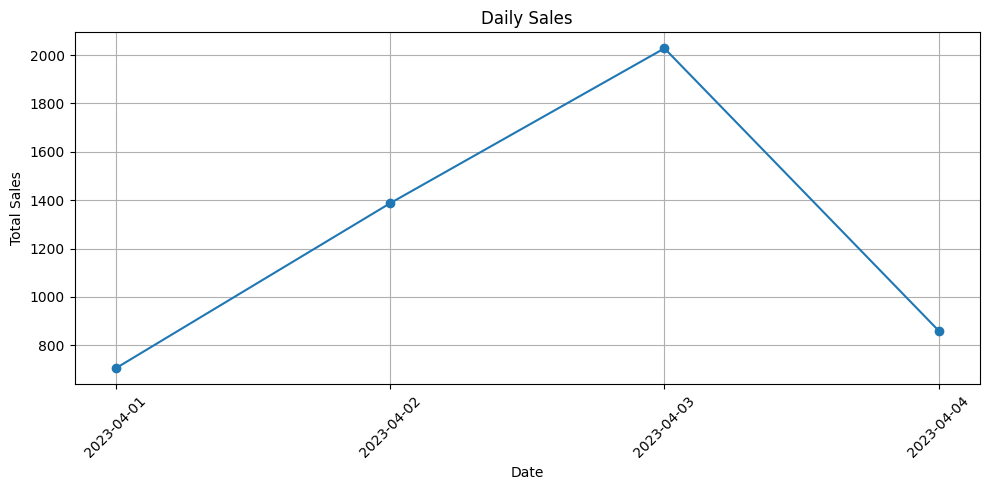

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates = [row[0] for row in data]
total_sales = [row[1] for row in data]

# Convert dates 
dates_plot = [mdates.date2num(date) for date in dates]


plt.figure(figsize=(10, 5))
plt.plot_date(dates_plot, total_sales, fmt='-', marker='o')
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# !pip install Faker

In [9]:
from faker import Faker
import random

# Faker
fake = Faker()

# Connessione al database
conn, cur = pg_connection()

# check se le tabelle esistono
cur.execute('''
SELECT EXISTS (
    SELECT 1
    FROM information_schema.tables
    WHERE table_name = 'customers'
)
''')
customers_exists = cur.fetchone()[0]
cur.execute('''
SELECT EXISTS (
    SELECT 1
    FROM information_schema.tables
    WHERE table_name = 'products'
)
''')
products_exists = cur.fetchone()[0]
cur.execute('''
SELECT EXISTS (
    SELECT 1
    FROM information_schema.tables
    WHERE table_name = 'orders'
)
''')
orders_exists = cur.fetchone()[0]

if customers_exists and products_exists and orders_exists:
    print('Tables already exist')
else:
    cur.execute('''
                CREATE TABLE customers (
                customer_id SERIAL PRIMARY KEY,
                first_name VARCHAR(50),
                last_name VARCHAR(50),
                email VARCHAR(100),
                phone_number VARCHAR(28),
                address VARCHAR(200)
                )''' )

    cur.execute('''
                CREATE TABLE products (
                product_id SERIAL PRIMARY KEY,
                name VARCHAR( 100),
                category VARCHAR(50),
                price DECIMAL(10,2),
                stock INT,
                description TEXT
                )''' )

    cur.execute('''
                CREATE TABLE orders (
                order_id SERIAL PRIMARY KEY,
                customer_id INT,
                product_id INT,
                quantity INT,
                order_date TIMESTAMP,
                FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
                FOREIGN KEY (product_id) REFERENCES products(product_id)
                )''' )


    # Inizializzazione del ciclo per inserire i dati dei clienti nella tabella 'customers'
    # Si esegue per 200 volte per generare dati di 200 clienti
    for _ in range(200):
        first_name = fake.first_name()  # Genera un nome casuale
        last_name = fake.last_name()    # Genera un cognome casuale
        email = fake.email()            # Genera un indirizzo email casuale
        phone_number = fake.phone_number()  # Genera un numero di telefono casuale
        address = fake.address()        # Genera un indirizzo casuale
        # Esegue l'inserimento dei dati del cliente nel database
        cur.execute("INSERT INTO customers (first_name, last_name, email, phone_number, address) VALUES (%s, %s, %s, %s, %s)",
                    (first_name, last_name, email, phone_number, address))

    categories = ['Electronics', 'Books', 'Clothing', 'Home', 'Toys']  # Lista delle categorie di prodotti
    for _ in range(200):
        name = fake.word().title()  # Genera un nome di prodotto casuale e lo formatta con la prima lettera maiuscola
        category = random.choice(categories)  # Seleziona una categoria casuale dalla lista
        price = round(random.uniform(10.99, 999.99), 2)  # Genera un prezzo casuale tra 10.99 e 999.99
        stock = random.randint(10, 100)  # Genera una quantità casuale di stock tra 10 e 100
        description = fake.text()  # Genera una descrizione casuale del prodotto
        # Esegue l'inserimento dei dati del prodotto nel database
        cur.execute("INSERT INTO products (name, category, price, stock, description) VALUES (%s, %s, %s, %s, %s)",
                    (name, category, price, stock, description))

    for _ in range(200):
        customer_id = random.randint(1, 200)  # Seleziona un ID cliente casuale tra 1 e 200
        product_id = random.randint(1, 200)  # Seleziona un ID prodotto casuale tra 1 e 200
        quantity = random.randint(1, 10)  # Genera una quantità casuale di prodotti ordinati tra 1 e 10
        order_date = fake.date_time_this_year()  # Genera una data casuale per l'ordine nell'anno corrente
        # Esegue l'inserimento dei dati dell'ordine nel database
        cur.execute("INSERT INTO orders (customer_id, product_id, quantity, order_date) VALUES (%s, %s, %s, %s)",
                    (customer_id, product_id, quantity, order_date))

# Commit e chiusura della connessione
conn.commit()
cur.close()
conn.close()



Plot

Per rendere più chiara la spiegazione della query SQL, possiamo considerare un esempio pratico usando dati fittizi. Creerò due tabelle semplici, `orders` e `products`, e poi seguirò i passaggi della query con i dati di esempio per mostrare come si trasformano attraverso ogni fase della query.

### Tabelle di Esempio

1. **Tabella `products`**:
   | product_id | name       | category    | price |
   |------------|------------|-------------|-------|
   | 1          | Tastiera   | Elettronica | 30    |
   | 2          | Mouse      | Elettronica | 10    |
   | 3          | Tazza      | Casa        | 5     |

2. **Tabella `orders`**:
   | order_id | product_id | order_date  | quantity |
   |----------|------------|-------------|----------|
   | 101      | 1          | 2024-04-01  | 10       |
   | 102      | 2          | 2024-04-02  | 15       |
   | 103      | 1          | 2024-05-01  | 5        |
   | 104      | 3          | 2024-05-02  | 20       |

### Passaggi della Query

1. **Join delle Tabelle**:
   Uniamo le tabelle `orders` e `products` per avere accesso contemporaneamente ai dettagli degli ordini e dei prodotti.

   | order_id | order_date  | product_id | quantity | name       | category    | price |
   |----------|-------------|------------|----------|------------|-------------|-------|
   | 101      | 2024-04-01  | 1          | 10       | Tastiera   | Elettronica | 30    |
   | 102      | 2024-04-02  | 2          | 15       | Mouse      | Elettronica | 10    |
   | 103      | 2024-05-01  | 1          | 5        | Tastiera   | Elettronica | 30    |
   | 104      | 2024-05-02  | 3          | 20       | Tazza      | Casa        | 5     |

2. **Calcolo del Ricavo**:
   Calcoliamo il ricavo (`revenue`) per ogni riga moltiplicando `price` per `quantity`.

   | order_date  | category    | revenue |
   |-------------|-------------|---------|
   | 2024-04-01  | Elettronica | 300     | (30 * 10)
   | 2024-04-02  | Elettronica | 150     | (10 * 15)
   | 2024-05-01  | Elettronica | 150     | (30 * 5)
   | 2024-05-02  | Casa        | 100     | (5 * 20)

3. **Raggruppamento per Mese e Categoria**:
   Raggruppiamo i dati per `order_month` e `category` e sommiamo il `revenue`.

   | order_month | category    | total_revenue |
   |-------------|-------------|---------------|
   | 2024-04     | Elettronica | 450           | (300 + 150)
   | 2024-05     | Elettronica | 150           |
   | 2024-05     | Casa        | 100           |

4. **Ordinamento dei Risultati**:
   Ordiniamo i risultati per `order_month` e `total_revenue` in ordine decrescente.

   | order_month | category    | total_revenue |
   |-------------|-------------|---------------|
   | 2024-04     | Elettronica | 450           |
   | 2024-05     | Elettronica | 150           |
   | 2024-05     | Casa        | 100           |

Questo esempio mostra come la query aggrega i dati per ottenere un'analisi mensile del ricavo per categoria, organizzando le informazioni in modo che sia facile visualizzare quali categorie e mesi hanno generato più entrate.

Questa query SQL è utilizzata per analizzare le vendite di un'azienda, raggruppando i dati per mese e categoria di prodotto per calcolare il ricavo totale. Si utilizza in un contesto dove abbiamo due tabelle principali: orders per gli ordini e products per i prodotti.


Selezione dei Dati (SELECT):
TO_CHAR(o.order_date, 'YYYY-MM') AS order_month: Questo comando converte la data dell'ordine, che è una data completa (anno, mese, giorno), in una stringa che contiene solo l'anno e il mese (es. 2024-04). Ciò permette di analizzare le vendite su base mensile. Il risultato di questa conversione viene chiamato order_month.

p.category: Semplicemente seleziona la categoria di ogni prodotto dall'ordine dalla tabella products.

SUM(p.price * o.quantity) AS revenue: Calcola il ricavo moltiplicando il prezzo di ogni prodotto per la quantità venduta in ciascun ordine, e poi sommando questi valori per ogni gruppo definito. Il risultato è il ricavo totale per categoria per mese.


Da Dove Vengono i Dati (FROM e JOIN):
FROM orders o JOIN products p ON o.product_id = p.product_id: La query inizia dalla tabella orders (abbreviata qui come o) e si unisce (JOIN) alla tabella products (abbreviata come p). L'unione è basata sul campo product_id che è presente in entrambe le tabelle, associando ogni ordine al dettaglio del prodotto corrispondente.

Raggruppamento dei Dati (GROUP BY):
GROUP BY order_month, p.category: Dopo aver calcolato il ricavo per ogni riga, la query raggruppa questi dati per order_month e category. Questo significa che tutti gli ordini dello stesso mese e della stessa categoria vengono aggregati per calcolare il totale del ricavo.

Ordinamento dei Risultati (ORDER BY):
ORDER BY order_month, revenue DESC: Infine, i risultati vengono ordinati. Prima per order_month (in modo che i mesi appaiano in ordine cronologico) e poi per revenue in ordine decrescente all'interno di ciascun mese, mostrando le categorie più redditizie per prime.

  Order Month     Category   Revenue
0     2024-01  Electronics  43152.33
1     2024-01         Toys  40341.17
2     2024-01     Clothing  32073.72
3     2024-01         Home  20478.65
4     2024-01        Books   7538.15
Category        Books  Clothing  Electronics      Home      Toys
Order Month                                                     
2024-01       7538.15  32073.72     43152.33  20478.65  40341.17
2024-02      33522.28  14066.89     33009.95  22615.34  17474.43
2024-03      12980.95  10069.39     46303.29  20617.21  36801.66
2024-04       9550.68  17411.34     32832.48  16665.42  20804.00


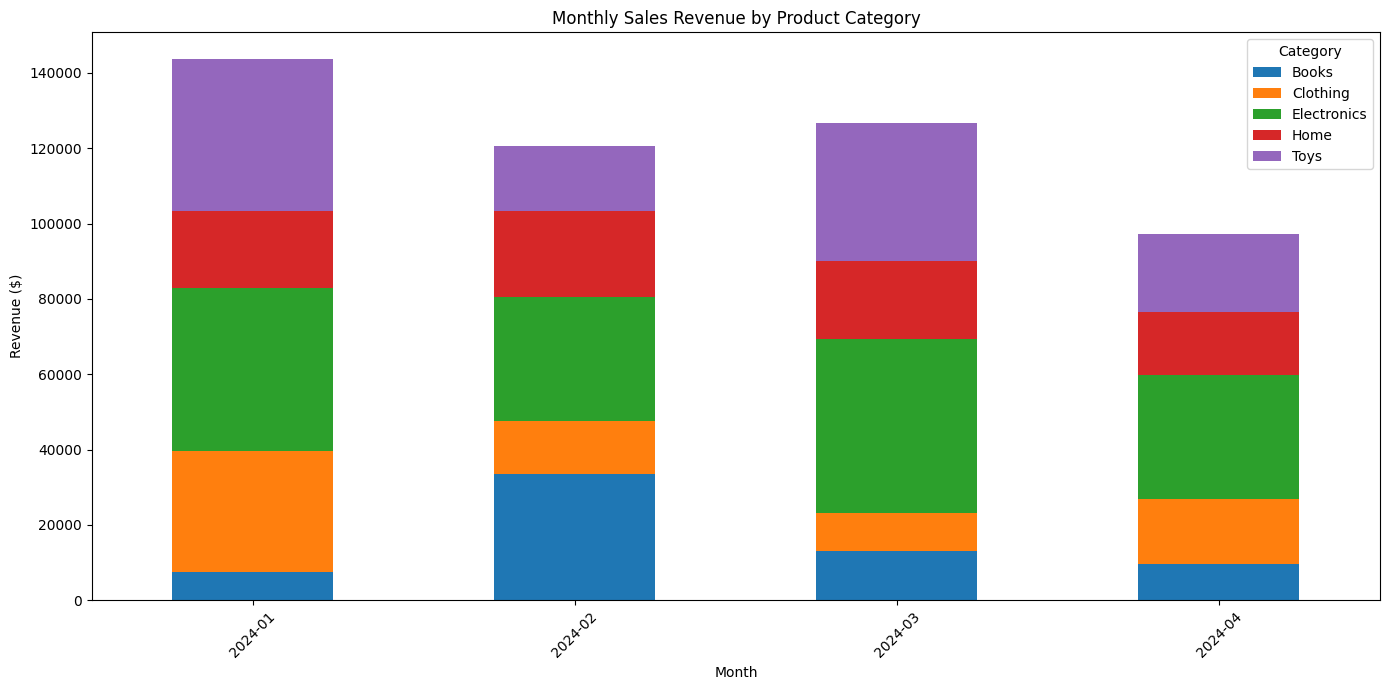

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Connessione al database
conn, cur = pg_connection()

import pandas as pd

cur.execute('''
SELECT
    TO_CHAR(o.order_date, 'YYYY-MM') AS order_month,
    p.category,
    SUM(p.price * o.quantity) AS revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY order_month, p.category
ORDER BY order_month, revenue DESC;
''')

data = cur.fetchall()
cur.close()
conn.close()


df = pd.DataFrame(data, columns=['Order Month', 'Category', 'Revenue'])
print(df.head())


df['Revenue'] = df['Revenue'].astype(float)

pivot_df = df.pivot(index='Order Month', columns='Category', values='Revenue').fillna(0)
print(pivot_df)


pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Monthly Sales Revenue by Product Category')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()